In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import warnings
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from scipy.sparse import csr_matrix, hstack

In [2]:
prospects = pd.read_csv("final.csv", encoding = "latin")

In [3]:
prospects['bigs'] = prospects['bigs'].astype('category', copy = False)
prospects['Pos'] = prospects['Pos'].astype('category', copy = False)

In [4]:
prospects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Id            2615 non-null   int64   
 1   Pos           2615 non-null   category
 2   Age           2615 non-null   int64   
 3   avg_year      2615 non-null   float64 
 4   avg_hit       2615 non-null   float64 
 5   avg_power     2615 non-null   float64 
 6   avg_run       2615 non-null   float64 
 7   avg_arm       2615 non-null   float64 
 8   avg_field     2615 non-null   float64 
 9   avg_fb        2615 non-null   float64 
 10  avg_control   2615 non-null   float64 
 11  avg_ovr       2615 non-null   float64 
 12  avg_best_off  2615 non-null   float64 
 13  avg_num_off   2615 non-null   int64   
 14  avg_avg_off   2615 non-null   float64 
 15  Text          2615 non-null   object  
 16  bigs          2615 non-null   category
dtypes: category(2), float64(11), int64(3), object(1)
mem

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

In [6]:
bow = CountVectorizer(preprocessor = preprocess_text, stop_words = 'english',
                     min_df = 10, ngram_range = (1,2))

In [7]:
text_col = bow.fit_transform(prospects.Text)

In [8]:
text_col.shape

(2615, 8256)

In [9]:
num_sub = prospects.iloc[:,2:-2]

In [10]:
num_col = StandardScaler().fit_transform(num_sub)

In [11]:
num_col.shape

(2615, 13)

In [12]:
cat_col = OneHotEncoder(handle_unknown = 'ignore').fit_transform(prospects.Pos[:, np.newaxis])

In [13]:
cat_col.shape

(2615, 8)

In [14]:
combined = hstack([csr_matrix(num_col), csr_matrix(cat_col), text_col])

In [15]:
combined.shape

(2615, 8277)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(combined, prospects.iloc[:,-1], train_size = .8, random_state = 42)

In [17]:
X_train_no_text = X_train[:,:21]
X_test_no_text = X_test[:,:21]

In [18]:
# example

In [19]:
fit_logistic = LogisticRegression()

In [20]:
fit_logistic.fit(X_train_no_text, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
fit_logistic.score(X_train_no_text, y_train)

0.8403441682600382

In [22]:
fit_logistic.score(X_test_no_text, y_test)

0.8374760994263862

In [23]:
preds = fit_logistic.predict(X_test_no_text)

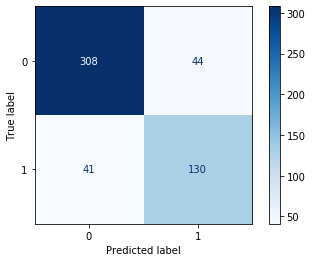

In [24]:
plot_confusion_matrix(fit_logistic, X_test_no_text, y_test,
                                 cmap = plt.cm.Blues, values_format = '.0f');

In [25]:
coefs = fit_logistic.coef_[0]

In [26]:
cols = list(prospects.columns.values[2:-2]) + ["1B","2B","3B","C","LHP","OF","RHP","SS"]

In [27]:
importances = pd.DataFrame(data = {"column": cols, "coef": coefs})

In [28]:
importances.sort_values('coef')

,column,coef
3,avg_power,-0.579976
4,avg_run,-0.330321
19,RHP,-0.329976
1,avg_year,-0.309060
11,avg_num_off,-0.273880
12,avg_avg_off,-0.268514
14,2B,-0.167806
6,avg_field,-0.157880
10,avg_best_off,-0.096949
17,LHP,-0.046815


In [29]:
# full grid search

In [30]:
pipe = Pipeline([('classifier', RandomForestClassifier())])

In [31]:
param_grid = [{'classifier': [LogisticRegression()]},
             {'classifier': [RandomForestClassifier()],
             'classifier__n_estimators': [10,50,100],
             'classifier__max_features': [3,5],
             'classifier__min_samples_split': [2,4]},
             {'classifier': [SVC()],
             'classifier__C': [0.1,1,10,100]},
             {'classifier': [GradientBoostingClassifier()],
             'classifier__n_estimators': [50,100],
             'classifier__learning_rate': [0.05,0.1,0.2]}]

In [32]:
fit_grid = GridSearchCV(pipe, param_grid, cv = 3, scoring = 'accuracy')

In [33]:
fit_grid_best = fit_grid.fit(X_train_no_text, y_train)

In [34]:
fit_grid_best.best_estimator_.get_params()['classifier']

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [35]:
fit_grid_best.score(X_train_no_text, y_train)

0.8637667304015296

In [36]:
fit_grid_best.score(X_test_no_text, y_test)

0.8393881453154876

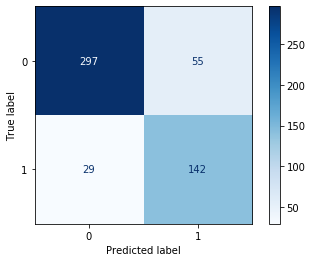

In [37]:
plot_confusion_matrix(fit_grid_best, X_test_no_text, y_test,
                                 cmap = plt.cm.Blues, values_format = '.0f');

In [38]:
# with text data

In [39]:
param_grid_text = [{'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [10,50,100],
                 'classifier__max_features': [3,5],
                 'classifier__min_samples_split': [2,4]},
                 {'classifier': [SVC()],
                 'classifier__C': [0.1,1,10,100]},
                 {'classifier': [GradientBoostingClassifier()],
                 'classifier__n_estimators': [50,100],
                 'classifier__learning_rate': [0.05,0.1,0.2]}]

In [40]:
pipe_text = Pipeline([('classifier', RandomForestClassifier())])

In [41]:
fit_grid_text = GridSearchCV(pipe_text, param_grid_text, cv = 3, scoring = 'accuracy')

In [42]:
fit_grid_text_best = fit_grid_text.fit(X_train, y_train)

In [43]:
fit_grid_text_best.best_estimator_.get_params()['classifier']

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [44]:
fit_grid_text_best.score(X_train, y_train)

0.904397705544933

In [45]:
fit_grid_text_best.score(X_test, y_test)

0.8604206500956023

In [46]:
# improvement

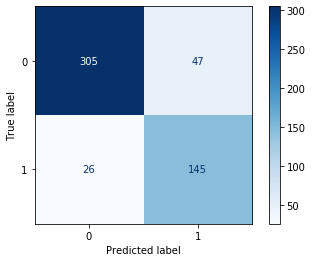

In [47]:
plot_confusion_matrix(fit_grid_text_best, X_test, y_test,
                                 cmap = plt.cm.Blues, values_format = '.0f');